# LAB Session 10 (21/12/2020)

First we generate the Higgs mass spectrum, with signal and background, and perform a fits to binned data. Then you can repeat the generation to emulate multiple experimens and perform some statistical analysis.

In order to help you with the excerise, the notebook provides the necessary steps to obtain a correct spectrum and fit it. Then you will be asked to answer a few questions by repeating some of the steps and make some plots.

The main steps are
- generate Gaussian signal
 - plot the distribution
- generate exponential background
 - plot the distribution 
- Plot the distribution of data by stacking signal and background
- Obtain binned data from histogram
- fit binned data with `curve_fit`
- compute the signal significance defined as $S/\sqrt B$

At this point you can repeat the above steps to perform a few studies and make some plots.

1. Fix the number of background events $N_B = 10000$ and vary the number of signal events $N_S$ in 
 `[10, 50, 100, 500, 1000]`
  - plot the signficance as a function of $N_S$
  - You can now change $N_B$ and remake the same plot and show the data for different values of $N_B$
  - how does the significance depend on $N_S$ and $N_B$ ?
 
 
2. Fix $N_B = 10000$ and $N_S = 200$. Vary the mass width between `[0.01, 0.2, 0.05, 0.10, 0.20, 0.50]`
  - plot the significance as a function of the mass width 
  - which mass width provide the best signal significance?


3. Fix $N_B = 10000$ and $N_S = 200$ and repeat the experiments 1000 times
  - for each experiment generate the number of signal and background events from a Poisson distribution
    - mean of signal events: 200
    - mean of background events: 10000
  - compute the significance for each experiment
  - plot the distribution of significance for all experiments
  - plot the distribution of $m_{fitted} - m_H$ for all experiments
  - fit to a Gaussian and print the fitted $\mu$ and $\sigma$

# Modules for this exercise

- `scipy.optimize` for fitting
- `scipy.integrate` for integration

In [30]:
import numpy as np
import matplotlib.pyplot as pl

import scipy.stats as stats

from scipy import optimize as op  
from scipy import integrate

# Parameters
- Num. of signal events
- Num. of background events
- Higgs mass
- Higgs width due to detector resolution (intrinsic width is negligible)

In [2]:
n_sig_0 = 100
n_bkg_0 = 10000

m_sig = 125 # GeV
w_sig = 0.02 # in %
w_sig *= m_sig

# Histogram data
boundaries and number of bins

In [3]:
x_min = 0 # GeV
x_max = 200 # GeV
n_bins = 100
bin_width = (x_max-x_min)/n_bins # GeV
print('%d bins from %.1f to %.1f'%(n_bins, x_min, x_max))
print('bin width: %.2f GeV'%(bin_width))

100 bins from 0.0 to 200.0
bin width: 2.00 GeV


## Generate signal sample

`n_sig` events with a Gaussian distribution around Higgs mass

In [4]:
signal = np.random.normal(m_sig, w_sig, n_sig_0)

## Plots signal distribution

Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

<IPython.core.display.Javascript object>


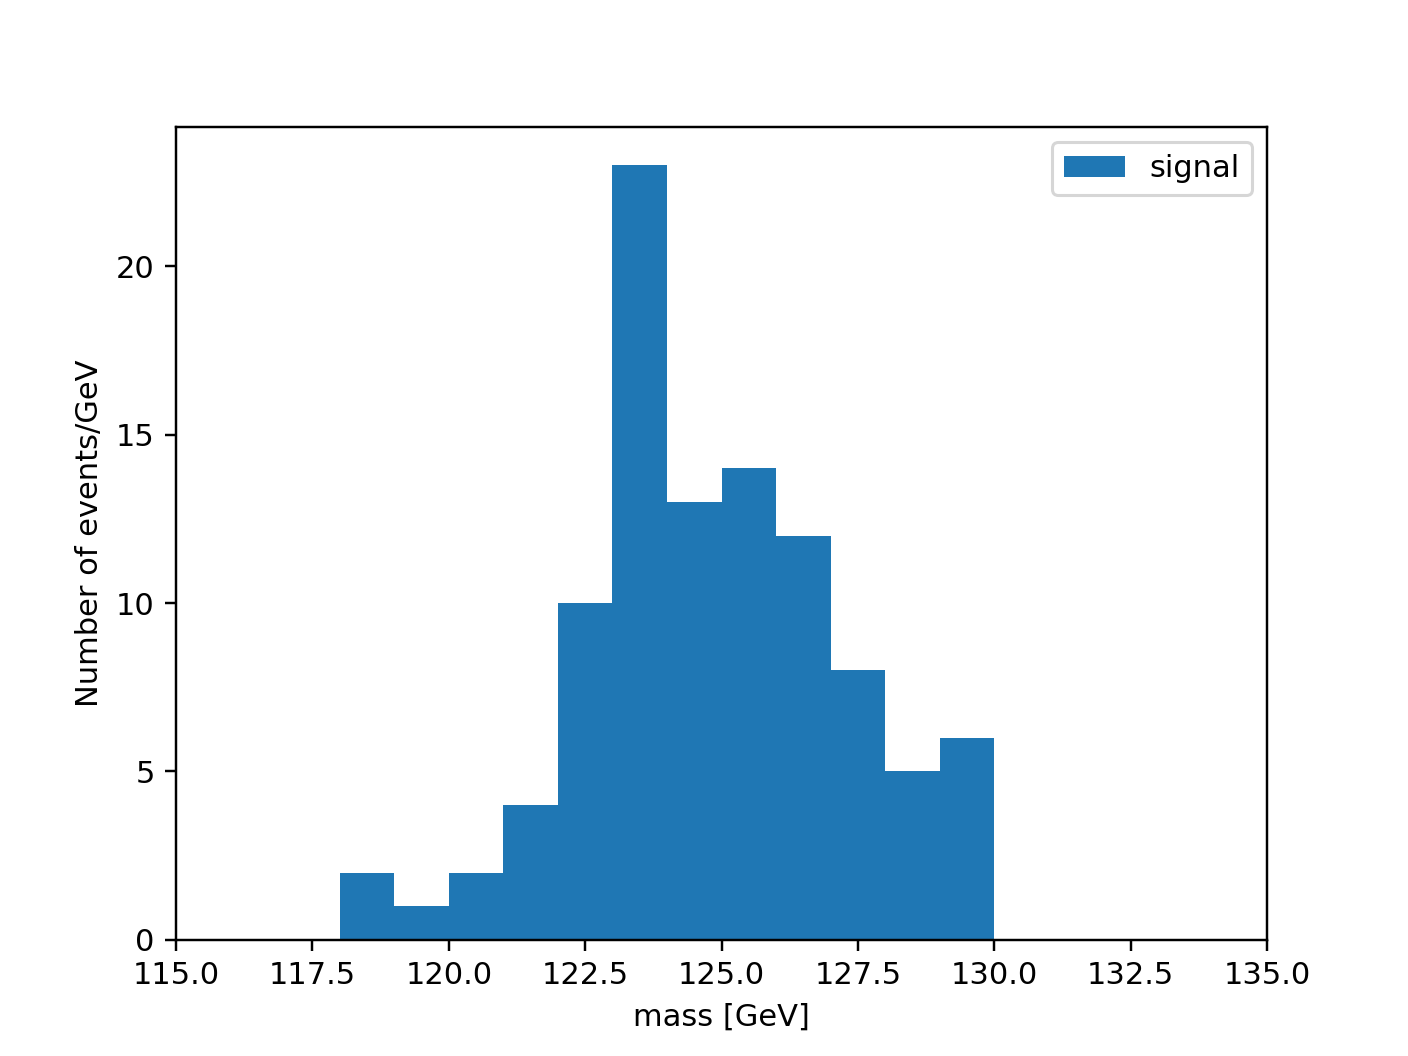

In [25]:
%matplotlib notebook
pl.hist(signal, bins=20, label='signal', range=(115,135))
pl.xlim(m_sig-5*w_sig, m_sig+5*w_sig)
pl.xlim(115,135)

pl.xlabel('mass [GeV]')
pl.ylabel('Number of events/GeV')

pl.legend()

## Generate background sample

`n_bkg` events with an exponential distribution. For example, you can use [numpy.random.exponential](https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html)

Choose an exponential parameter that populates bins with tens of events for mass of 200 GeV. for example use `scale=80` in [numpy.random.exponential]

In [6]:
a_rate = 80.
background = np.random.exponential(a_rate, n_bkg_0)

## Plots background distribution
Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

Useful options:
- _bins=n_ : fix number of bins to _n_
- _hist=options_ : for example _hist='step'_ to show empty histogram
- _range=(min,max)_ : fix the boundaries of data in histogram. 
  - **NB**: this is different than using _xlim(min,max)_ which is only for visualization


<IPython.core.display.Javascript object>


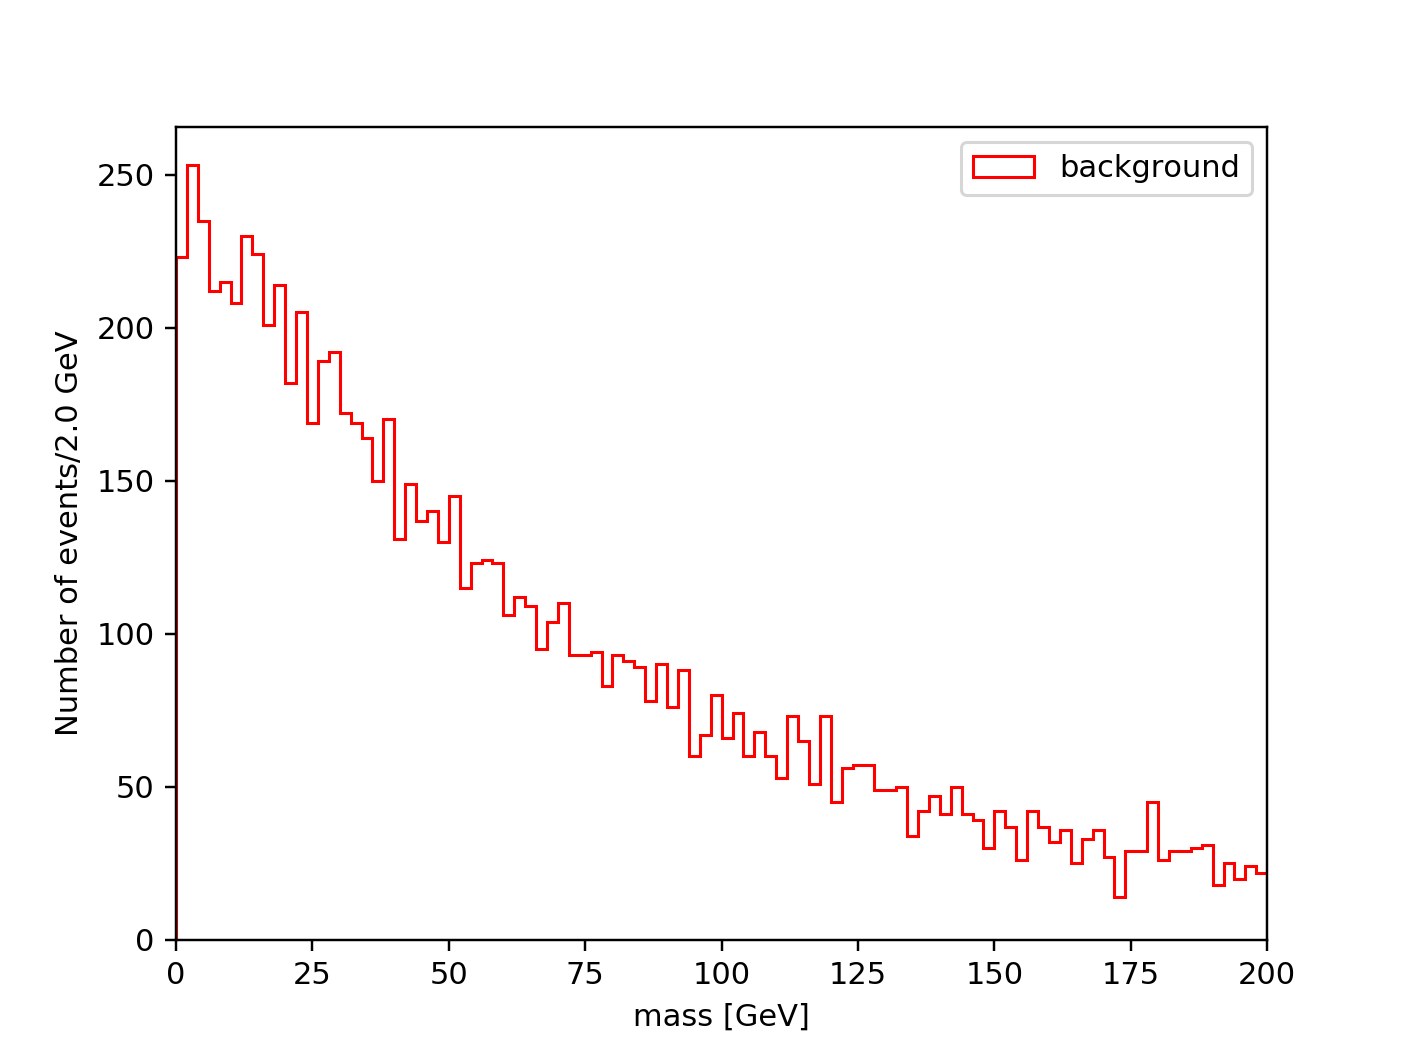

In [26]:
%matplotlib notebook
pl.hist(background, bins=n_bins, label='background', color='red', histtype='step', range=(x_min,x_max))
pl.xlim(x_min, x_max)
pl.xlabel('mass [GeV]')
pl.ylabel('Number of events/%.1f GeV'%(bin_width))


pl.legend()

## Stack signal and background data in the same histogram

If you have two data arrays `signal` and `background` try the following options to stack signal on top of the background

```python
pl.hist( (background,signal), bins=n_bins, label=('backgroud', 'signal'), color=('red','blue'), stacked=True , 
        histtype='step', range=(x_min,x_max) )
```

<IPython.core.display.Javascript object>


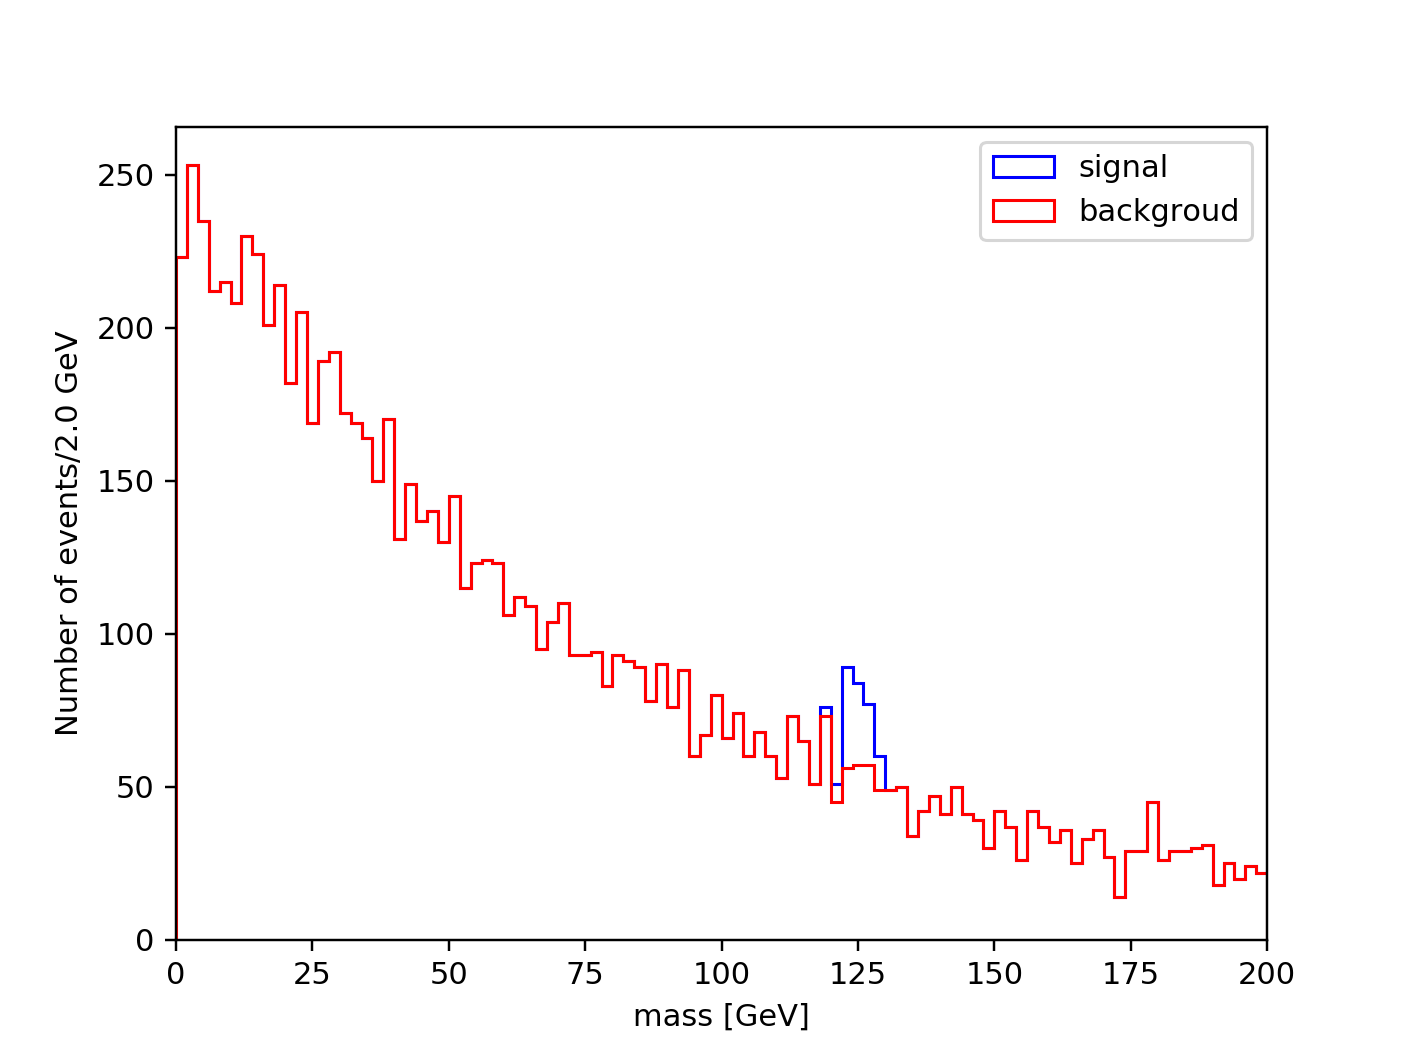

In [27]:
%matplotlib notebook
pl.hist( (background,signal), bins=n_bins, label=('backgroud', 'signal'), color=('red','blue'), stacked=True , 
        histtype='step', range=(x_min,x_max) )
pl.xlim(x_min,x_max)
pl.xlabel('mass [GeV]')
pl.ylabel('Number of events/%.1f GeV'%(bin_width))

pl.legend()

## Merge signal and background samples

The data collected in an experiment contains both signal and background. We have simulated the two samples separately and they can be merged with [numpy.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)

```python
a = np.array(...)
b = np.array(...)

data = np.concatenate( (a,b) )
```
Note the first positional argument of the function is a tuple of numpy arrays.

In [9]:
data = np.concatenate( (signal,background)  )

## Binned data

The data sample so far is unbinned: we have a number of signal and background events. 

Now we can create a binned version to be fitted. This is achieved with the `pyplot.hist` function which returns a list of counts for each bin and the bin boundaries
```python

binned_data, bins, _ = pl.hist( data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min,x_max) )

```

plot the merged data and make sure it is indeed the sum of the two sub-samples.

<IPython.core.display.Javascript object>


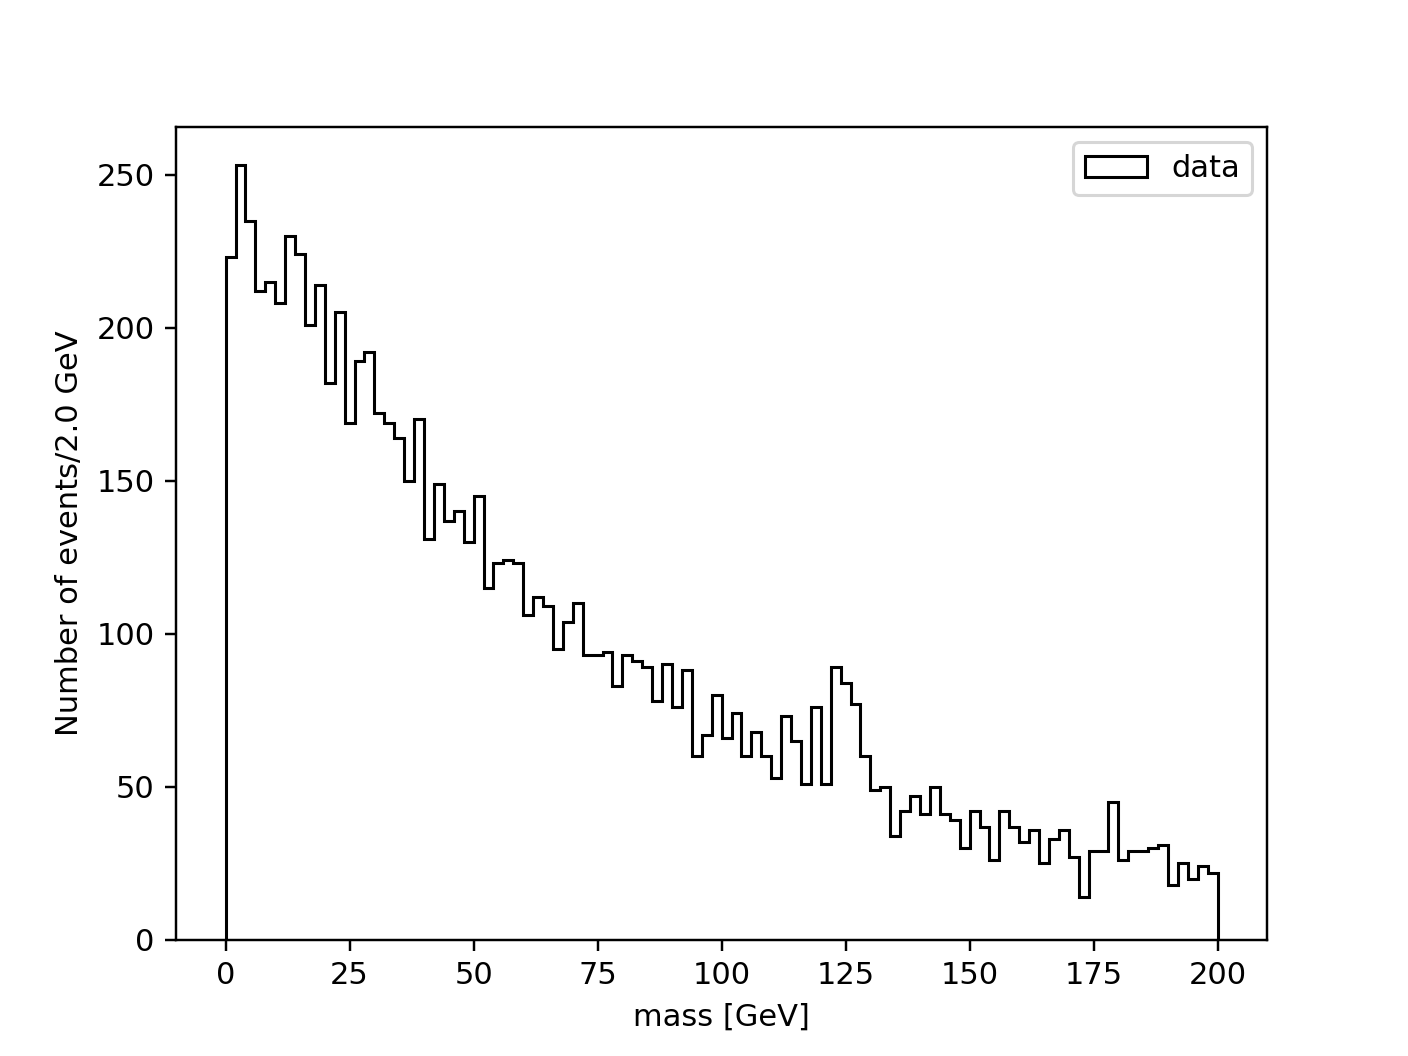

In [28]:
%matplotlib notebook
binned_data, bins, _ = pl.hist( data, bins=n_bins, label='data', color='black', histtype='step', range=(x_min,x_max) )
pl.xlabel('mass [GeV]')
pl.ylabel('Number of events/%.1f GeV'%(bin_width))

pl.legend()

## `bins` list

The list `bins` contains `n_bins + 1` values: edge of the first bin ... edge of the last bin. You can verify this easily

In [11]:
print(len(bins))
print(bins[:10])
print(bins[-10:])

101
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[182. 184. 186. 188. 190. 192. 194. 196. 198. 200.]


## center of bins (data along x axis)

Using a comprehension, prepare a list `center_bins` from `bins` with length of `n_bins` which contains the center of each bin of the histogram

In [12]:
center_bins = [ bins[i]+0.5*bin_width for i in range(len(bins)-1) ]


In [13]:
print(len(center_bins))
print(center_bins[:5])
print(center_bins[-5:])

100
[1.0, 3.0, 5.0, 7.0, 9.0]
[191.0, 193.0, 195.0, 197.0, 199.0]


## bin count (data along y axis)

Verify that the list `binned data` should have length `n_bins` 

In [14]:
print(len(binned_data))
print(binned_data[:10])
print(binned_data[-10:])

100
[223. 253. 235. 212. 215. 208. 230. 224. 201. 214.]
[26. 29. 29. 30. 31. 18. 25. 20. 24. 22.]


## Fitting the histogram

We want to fit the binned data (`binned_data` as a function of `center_bins`) using the [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function

The fir model has to be the sum of a Gaussian and an exponential.

Recall that [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) has the following structure
```python
curve_fit( function, x_data, y_data , ... )
```

Define three functions with proper arguments
1. `sig(x, Norm, mean, width)` for the signal Gaussian
2. `bkg(x, Norm, alpha)` for the background exponential
3. `total(x,NormSig, mean, width, NormBkg, alpha)` sum of signal and background

There are a total of 5 parameters to be fitted from data

In [15]:
def sig(x,A,m,w):
    return A*np.exp(-(x-m)**2/(2*w**2))

def bkg(x,A,alpha):
    return A*np.exp(-x/alpha)

def model(x, S, m, w, B, alpha):
    return sig(x,S,m,w)+bkg(x,B, alpha)


## Plot fit function

As a sanity check you can plot the 3 functions and make sure they are implemented correctly.
```python

pl.plot(x, sig(...), 'b-', label='signal')

pl.plot(x, bkg(...), 'r--', label='background', )

pl.plot(x, total(...), 'navy', label='total')

```

<IPython.core.display.Javascript object>


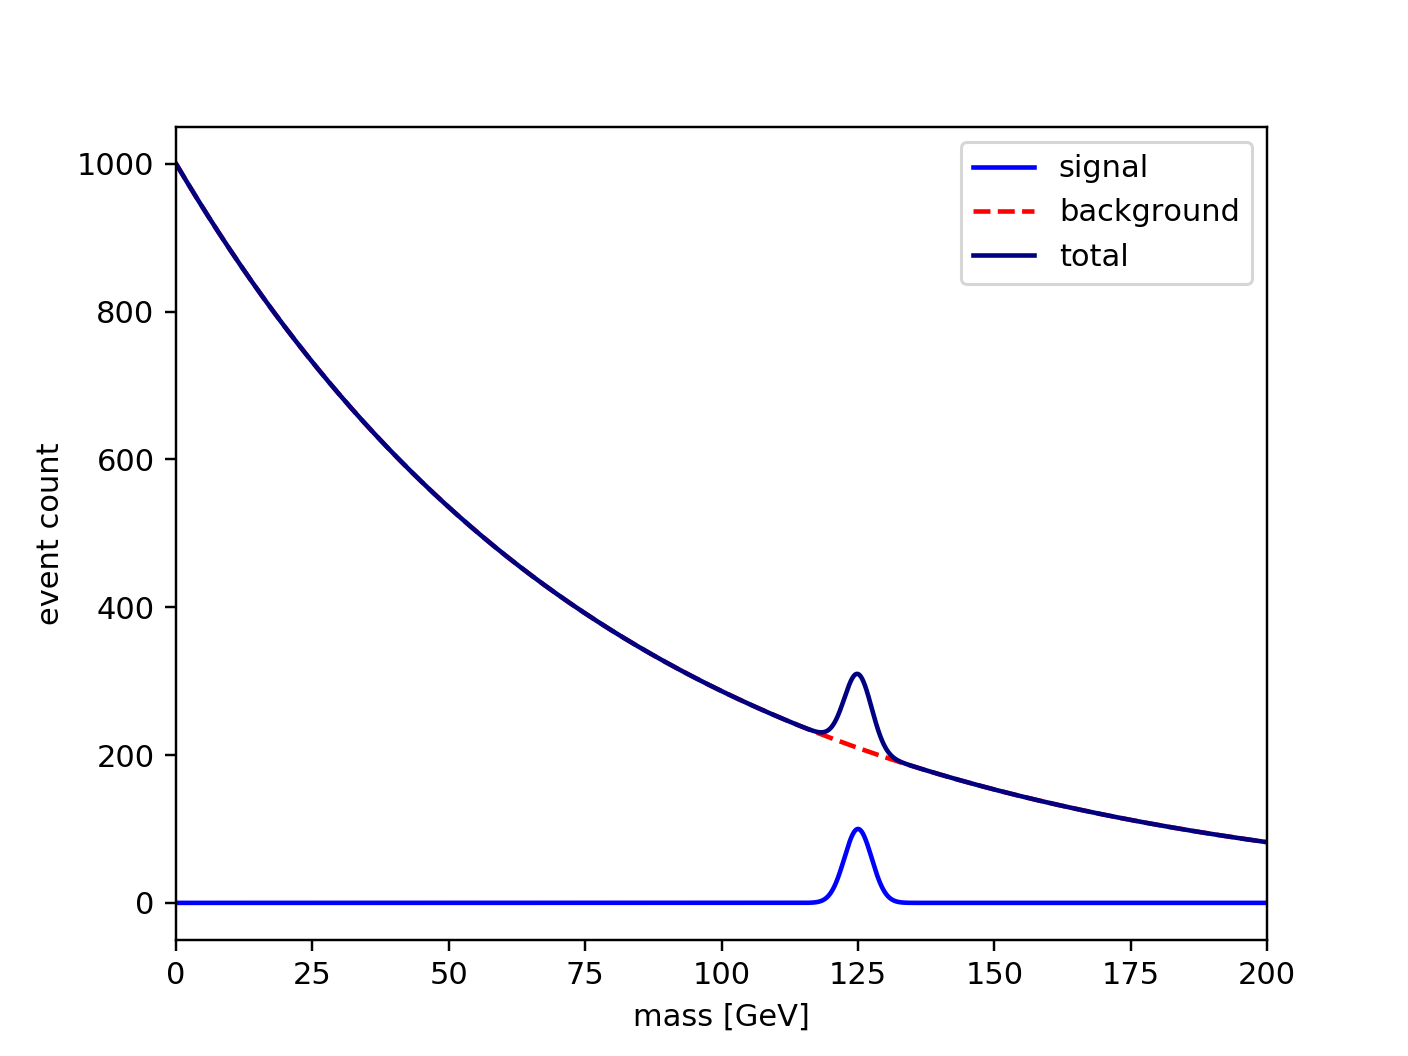

In [29]:
%matplotlib notebook

alpha = 80
x = np.linspace(x_min, x_max, 10000)

pl.xlim(x_min, x_max)
pl.plot(x, sig(x, 100, m_sig, w_sig), 'b-', label='signal')

pl.plot(x, bkg(x,1000,alpha), 'r--', label='background', )

pl.plot(x, model(x,100,m_sig,w_sig,1000,alpha), 'navy', label='total')
pl.xlabel('mass [GeV]')
pl.ylabel('event count')
pl.legend()

## Initial conditions for the fit

Since there are 5 parameters and the data varies a lot across the spectrum, it is always a good practice to provide some initial values for the parameters to be fitted. This is done with the argument `p0` in [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
```python
pars, pars_cov = op.curve_fit(..., p0=[500, m_sig, w_sig, 1000, alpha])
```

Recall that `pars` are the fitted parameters (in the order they appear in the definition of the fit function) and `pars_cov` is their covariance matrix that can be used to compute the uncertainty on each fitted parameter

In [17]:
pars, pars_cov = op.curve_fit(model, center_bins, binned_data, p0=[1000, m_sig, w_sig, 1000, alpha])

## Fitted parameters
- print the parameters
- print the covariance matrix

are the fitted values close to the generated values?

In [18]:
print('==== fitted parameters ===\n', pars)
print('==== covariance matrix\n', pars_cov)

==== fitted parameters ===
 [ 36.01925319 124.90258676   2.47799423 249.73305489  79.8563846 ]
==== covariance matrix
 [[ 5.63006812e+01 -1.24887542e-03 -2.46113301e+00  1.02380800e+00
  -1.12228566e+00]
 [-1.24887542e-03  3.51275240e-01 -1.59772181e-04  4.05261708e-03
   8.34323776e-04]
 [-2.46113301e+00 -1.59772181e-04  3.63656299e-01  1.39795766e-01
  -1.53895718e-01]
 [ 1.02380800e+00  4.05261708e-03  1.39795766e-01  8.88531848e+00
  -3.22675243e+00]
 [-1.12228566e+00  8.34323776e-04 -1.53895718e-01 -3.22675243e+00
   2.20800907e+00]]


## Plot the histogram and fit

- plot th data histogram
- Overlay the fitted function (total) with the fitted parameters
- overlay the background function with the fitted parameters
- print the fitted parameters with proper legend on the screen


<IPython.core.display.Javascript object>


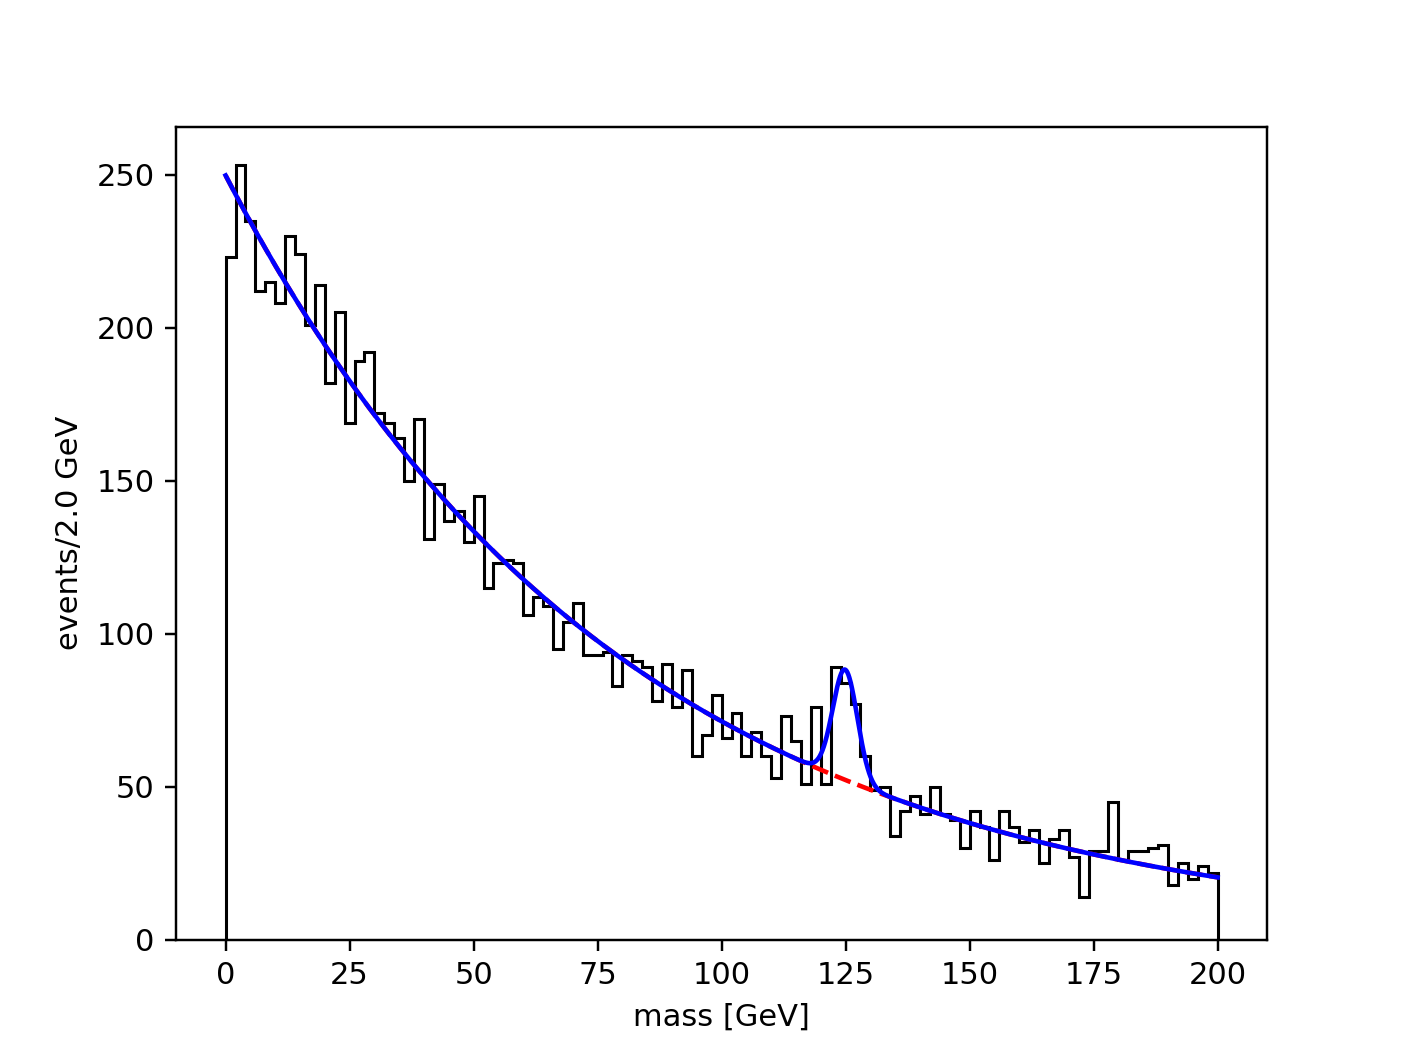

Text(0, 0.5, 'events/2.0 GeV')

In [19]:
%matplotlib notebook
pl.hist( data, bins=n_bins, label='data', color='black', histtype='step', range=(x_min,x_max) )

x = np.linspace(x_min, x_max, 10000)
pl.plot(x, bkg(x, *pars[3:]), 'r--', label='background function')
pl.plot(x, model(x, *pars), 'b-', label='fitted function')
pl.xlabel('mass [GeV]')
pl.ylabel('events/%.1f GeV'%(bin_width))

# Signal Significance

The signal significance is defined as $S/\sqrt{B}$ where $S = \int_a^b sig(m)\, dm$ and $B = \int_a^b bkg(m)\, dm$ with $a = m_{\rm fitted} - 3\sigma_{\rm fitted}$ and $b = m_{\rm fitted} + 3\sigma_{\rm fitted}$

In order to compute the definite integral, you can use [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)

For example to integrate `func` in `[x_min, x_max]` 
```python 

def poly1(x, a, b):
    return a*x + b

x_min = 3
x_max =  10

m = 2
q = 3

res = scipy.integrate.quad( poly1, x_min, x_max, args=(m,q) )
```

`res` is a list with two elements
- the value of the integral `res[0]`
- its uncertainty `res[1]`

## compute S

In [20]:
fitted_mass = pars[1]
fitted_width = pars[2]

a = fitted_mass-3.*fitted_width
b = fitted_mass+3.*fitted_width

In [21]:
I_sig = integrate.quad( sig, a, b, args=(pars[0],pars[1],pars[2]) )
print(I_sig)


(223.12633740968238, 2.4771999772646436e-12)


## compute B

In [22]:
I_bkg = integrate.quad( bkg, a, b, args=(pars[3],pars[4]) )
print(I_bkg)

(778.1779659232674, 8.639510950239819e-12)


## compute significance and print the result

In [23]:
print('integral of signal between %.2f -> %.2f: %.2f'%(a,b, I_sig[0]))
print('integral of signal between %.2f -> %.2f: %.2f'%(a,b, I_bkg[0]))

integral of signal between 117.47 -> 132.34: 223.13
integral of signal between 117.47 -> 132.34: 778.18


In [24]:
signal_significance = I_sig[0]/np.sqrt(I_bkg[0])
print("signal significance: ", signal_significance)

signal significance:  7.998551985723365


# Exercise 1

1. Fix the number of background events $N_B = 10000$ and vary the number of signal events $N_S$ in 
 `[10, 50, 100, 500, 1000]`
  - plot the signficance as a function of $N_S$
  - You can now change $N_B$ and remake the same plot and show the data for different values of $N_B$
  - how does the significance depend on $N_S$ and $N_B$ ?
 

# Exercise 2

2. Fix $N_B = 10000$ and $N_S = 200$. Vary the mass width between `[0.01, 0.2, 0.05, 0.10, 0.20, 0.50]`
  - plot the significance as a function of the mass width 
  - which mass width provide the best signal significance?

# Exercise 3


3. Fix $N_B = 10000$ and $N_S = 200$ and repeat the experiments 1000 times
  - for each experiment generate the number of signal and background events from a Poisson distribution
    - mean of signal events: 200
    - mean of background events: 10000
  - compute the significance for each experiment
  - plot the distribution of significance for all experiments
  - plot the distribution of $m_{fitted} - m_H$ for all experiments
  - fit to a Gaussian and print the fitted $\mu$ and $\sigma$